## Feature Engineering and CV based Winners' Solutions

Try to use MAP@7 as `feval` for xgboost, failed because no way to tell xgboost how to group results by users. **Can only do this after train is finished.**

New in this notebook:
- A hacky implementation of MAP@7 evaluation. 
- This method is suitable when training on one month and validate on another month, since ncodpers is the key in ground truth dictionaries.
- This method **only works if the MAP functions and training codes are in the same notebook**.
- The MAP values shown during training is averaged by the number of customers with new products, so very different from LB. But it gives a sense of if the algorithm is good or not.

To-do: 
- mean encoding of products grouped by combinations of: canal_entrada, segmento, cod_prov
- Time since change and lags for a few non-product features: 
    - segmento
    - ind_actividad_cliente
    - cod_prov
    - canal_entrada
    - indrel_1mes
    - tiprel_1mes


Features:
- before eda_4_29
    - average of products for each (customer, product) pair
    - exponent weighted average of products each (customer, product) pair
    - time since presence of products, distance to the first 1
    - time to the last positive flank (01)
    - time to the last negative flank (10)
    - time to the last 1, to the nearest product purchase
    - time to the first 1, to the first product purchase
    - Trained@2015-06-28, validated@2015-12-28, mlogloss=1.28481
    - Private score: 0.0302054, public score: 0.0298683
- before eda_4_25
    - customer info in the second month
    - products in the first month
    - combination of first and second month `ind_actividad_cliente`
    - combination of first and second month `tiprel_1mes`
    - combination of first month product by using binary number (`target_combine`)
    - encoding `target_combine` with 
        - mean number of new products
        - mean number of customers with new products
        - mean number of customers with each new products
    - Count patterns in the last `max_lag` months
    - Number of month to the last time the customer purchase each product
        - CV@2015-12-28: mlogloss=1.29349
        - Private score: 0.0302475, public score: 0.0299266
- eda_4_25
    - Use all available history data
        - E.g., for 2016-05-28 train data, use all previous months, for 2015-02-28, use 1 lag month. 
        - Need to create test set that use the same amount of previous months for each training data set. 
        - This is from [the second winner's solution](https://www.kaggle.com/c/santander-product-recommendation/discussion/26824), his bold part in paragraph 4.
    - Combine models trained on 2016-05-28 and 2015-06-28:
        - Private score: 0.0304583, public score: 0.0300839
        - This is to catch both seasonality and trend, presented in 2015-06-28 and 2016-05-28, respectively. 
        - This idea is mentioned by many winners, like [11-th winner](https://www.kaggle.com/c/santander-product-recommendation/discussion/26823) and [14-th winner](https://www.kaggle.com/c/santander-product-recommendation/discussion/26808)

- eda_4_27
    - put 2015-06-28 and 2016-05-28 in the same data set, with the same lag=5
        - Private score:0.0303096, public score: 0.0299867
        - Different as [11-th winner's discussion](https://www.kaggle.com/c/santander-product-recommendation/discussion/26823)
            > We tested this by adding 50% of May-16 data to our June model and sure enough, we went from 0.0301 to 0.0303. Then, we built separate models for Jun and May, but the ensemble didn’t work. We weren’t surprised because June data is better for seasonal products, and May data is better for trend products. And vice-versa, June data is bad for trend products and May data is bad for seasonal products. So, they sort of cancelled each other out.

        - But my score is always worse than theirs, maybe this is the reason why we have different observations

# Compare two weights

In [1]:
from santander_helper import *

In [5]:
param = {'objective': 'multi:softprob', 
         'eta': 0.05, 
         'max_depth': 8, 
         'silent': 1, 
         'num_class': len(target_cols),
         'eval_metric': 'mlogloss',
         'min_child_weight': 1,
         'subsample': 0.7,
         'colsample_bytree': 0.7,
         'seed': 0}
num_rounds = 250
month_train = '2015-06-28'
month_val = '2016-05-28'

history, model_dict = cv_month(param, num_rounds, month_train, month_val, n_repeat=5, random_seed=0,
                    lag_train=5, lag_val=5, weight_set=(0, 1), verbose_eval=False)

Start arithmetic weight
##################################################
Train with weight 0, repetition 0 of 5
Validate logloss = 0.94431, MAP@7 = 0.85455, time = 21.33 min
--------------------------------------------------

Train with weight 0, repetition 1 of 5
Validate logloss = 0.95290, MAP@7 = 0.85296, time = 21.58 min
--------------------------------------------------

Train with weight 0, repetition 2 of 5
Validate logloss = 0.95678, MAP@7 = 0.85212, time = 21.46 min
--------------------------------------------------

Train with weight 0, repetition 3 of 5
Validate logloss = 0.95117, MAP@7 = 0.85361, time = 21.50 min
--------------------------------------------------

Train with weight 0, repetition 4 of 5
Validate logloss = 0.95916, MAP@7 = 0.85025, time = 21.46 min
--------------------------------------------------


Start exponential weight
##################################################
Train with weight 1, repetition 0 of 5
Validate logloss = 1.00326, MAP@7 = 0.85293,

In [9]:
history.head()

weight_index         0                                                    \
repetition           0                                       1             
data_set         train                 val               train             
metrics       mlogloss     MAP@7  mlogloss     MAP@7  mlogloss     MAP@7   
0             2.664320  0.883373  2.688444  0.842370  2.664812  0.882952   
1             2.468741  0.888642  2.508741  0.848428  2.467889  0.890430   
2             2.314738  0.890530  2.372343  0.851237  2.313708  0.892165   
3             2.187301  0.892101  2.270662  0.852917  2.186152  0.892988   
4             2.078687  0.893400  2.172239  0.853816  2.077416  0.894165   

weight_index                                            ...            1  \
repetition                               2              ...            2   
data_set           val               train              ...          val   
metrics       mlogloss     MAP@7  mlogloss     MAP@7    ...     mlogloss   
0             2.695117  0.838866  2.663501  0.884786    ...     2.706740   
1             2.514641  0.849975  2.466799  0.890292    ...     2.534373   
2             2.375700  0.852317  2.313784  0.891570    ...     2.397446   
3             2.275885  0.853465  2.186125  0.893160    ...     2.285661   
4             2.181026  0.853955  2.077559  0.893592    ...     2.192081   

weight_index                                                              \
repetition                     3                                       4   
data_set                   train                 val               train   
metrics          MAP@7  mlogloss     MAP@7  mlogloss     MAP@7  mlogloss   
0             0.839884  2.677466  0.884268  2.701618  0.843742  2.677309   
1             0.846818  2.488288  0.888461  2.527698  0.848953  2.486946   
2             0.848410  2.339339  0.890836  2.398123  0.850797  2.338260   
3             0.847670  2.215914  0.892835  2.285579  0.852127  2.214861   
4             0.849666  2.109977  0.894087  2.191470  0.852173  2.109944   

weight_index                                
repetition                                  
data_set                     val            
metrics          MAP@7  mlogloss     MAP@7  
0             0.885190  2.707646  0.844263  
1             0.890434  2.534644  0.845873  
2             0.892169  2.401685  0.849027  
3             0.893767  2.290860  0.850842  
4             0.894497  2.197528  0.851567  

[5 rows x 40 columns]

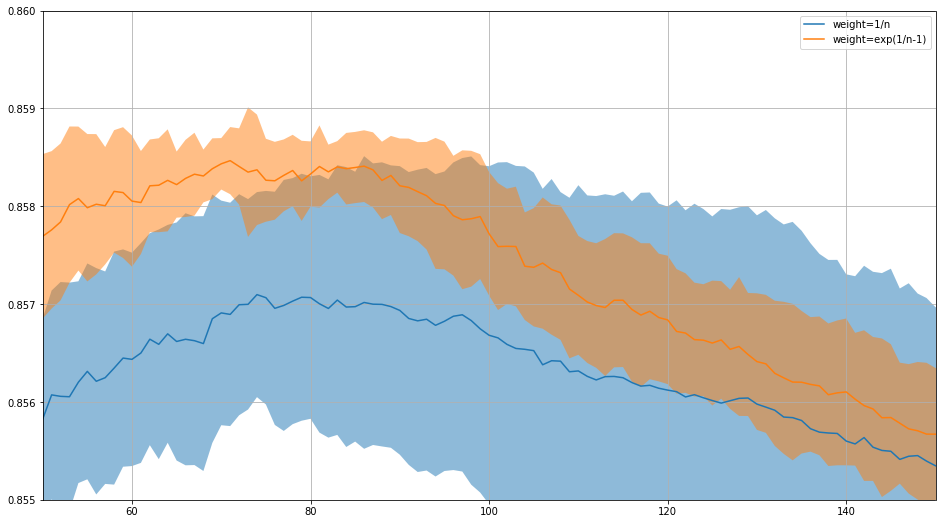

In [42]:
w0_val_map_mean = history.xs(axis=1, level=[0, 2, 3], key=(0, 'val', 'MAP@7')).mean(axis=1)
w0_val_map_std = history.xs(axis=1, level=[0, 2, 3], key=(0, 'val', 'MAP@7')).std(axis=1)
w1_val_map_mean = history.xs(axis=1, level=[0, 2, 3], key=(1, 'val', 'MAP@7')).mean(axis=1)
w1_val_map_std = history.xs(axis=1, level=[0, 2, 3], key=(1, 'val', 'MAP@7')).std(axis=1)

plt.figure(figsize=(16, 9))
plt.plot(w0_val_map_mean, label='weight=1/n')
plt.fill_between(history.index, w0_val_map_mean-w0_val_map_std, w0_val_map_mean+w0_val_map_std, alpha=0.5)
plt.plot(w1_val_map_mean, label='weight=exp(1/n-1)')
plt.fill_between(history.index, w1_val_map_mean-w1_val_map_std, w1_val_map_mean+w1_val_map_std, alpha=0.5)
# plt.plot(history.xs(axis=1, level=[1, 2, 3], key=(0, 'val', 'MAP@7')), alpha=0.25)
plt.grid()
plt.xlim(50, 150)
plt.ylim(0.855, 0.86)
plt.legend()

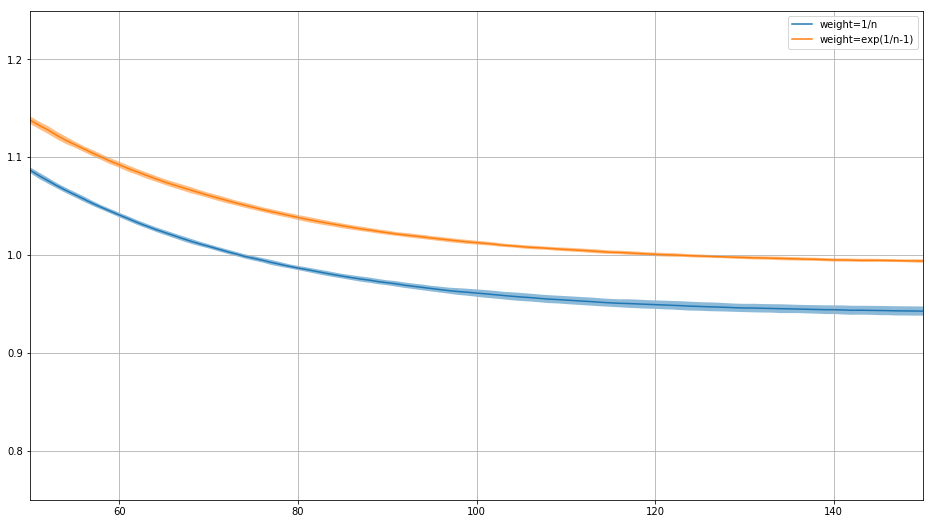

In [41]:
w0_val_log_mean = history.xs(axis=1, level=[0, 2, 3], key=(0, 'val', 'mlogloss')).mean(axis=1)
w0_val_log_std = history.xs(axis=1, level=[0, 2, 3], key=(0, 'val', 'mlogloss')).std(axis=1)
w1_val_log_mean = history.xs(axis=1, level=[0, 2, 3], key=(1, 'val', 'mlogloss')).mean(axis=1)
w1_val_log_std = history.xs(axis=1, level=[0, 2, 3], key=(1, 'val', 'mlogloss')).std(axis=1)

plt.figure(figsize=(16, 9))
plt.plot(w0_val_log_mean, label='weight=1/n')
plt.fill_between(history.index, w0_val_log_mean-w0_val_log_std, w0_val_log_mean+w0_val_log_std, alpha=0.5)
plt.plot(w1_val_log_mean, label='weight=exp(1/n-1)')
plt.fill_between(history.index, w1_val_log_mean-w1_val_log_std, w1_val_log_mean+w1_val_log_std, alpha=0.5)
# plt.plot(history.xs(axis=1, level=[1, 2, 3], key=(0, 'val', 'MAP@7')), alpha=0.25)
plt.grid()
plt.xlim(50, 150)
plt.ylim(0.75,1.25)
plt.legend()